In [1]:
from time import time
from datetime import datetime, timedelta
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from IPython.core.display import display, HTML
import matplotlib as mpl
from matplotlib import tri as mtri
mpl.use("pgf")

from matplotlib import pyplot as plt
#plt.rc('text',usetex=True)
plt.rc('figure',figsize=(5.05,3.1),dpi=100)
#plt.rc('text.latex',preamble=[r'\usepackage[]{libertine}',r'\usepackage[libertine]{newtxmath}'])
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

# Libraries to read data from NetCDF files
# xarray and netCDF4 can do much the same thing
# but xarray is slightly more high-level and has more features
# and is sometimes more annoying (in my opinion)
import xarray as xr
import netCDF4 as nc

# library for coordinate transformations
import pyproj

# Nice colormaps for oceanography, install from conda
import cmocean

#%matplotlib inline

/home/arne/anaconda3/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
def get_data_subset(data, xmin, xmax, ymin, ymax, Nz, Nt):
    # Creating a rotated subset and calculating a trajectory
    # using nearest-neighbour interpolation, to show an example
    
    # Coordinates (unit m)
    xc = np.array(data.variables['xc'][:])
    yc = np.array(data.variables['yc'][:])
    zc = np.array(data.variables['zc'][:])
    # Time coordinate is given as "days since 2013-06-01 00:00"
    # and must be converted to seconds
    tc = np.array(data.variables['time'][:]) * 24*60*60

    # Velocity components (unit m/s)
    # The current components are stored as u_east, v_north and the weirdly named w_velocity, which is the z-component
    u_east  = data.variables['u_east']
    v_north = data.variables['v_north']
    w_up    = data.variables['w_velocity']

    # Selecting xy subset bounds based on above plot
    # showing coordinate axis in meters
    imin = np.searchsorted(xc, xmin)
    imax = np.searchsorted(xc, xmax)
    jmin = np.searchsorted(yc, ymin)
    jmax = np.searchsorted(yc, ymax)
    # And top 20 layers and first 12 hours (36 timesteps)
    Ny = jmax - jmin
    Nx = imax - imin
    u = np.zeros_like(u_east[:Nt, :Nz, jmin:jmax, imin:imax])
    v = np.zeros_like(u_east[:Nt, :Nz, jmin:jmax, imin:imax])
    # w can be used directly
    # using np.array to convert from netCDF variable object
    # (which behaves mostly like an array) to an actual array
    w = np.array(w_up[:Nt, :Nz, jmin:jmax, imin:imax].filled(0.0))

    # Find rotation angle (different for each cell)
    dx = xc[1] - xc[0]
    dy = yc[1] - yc[0]
    x0 = data.false_easting
    y0 = data.false_northing
    x, y = np.meshgrid(xc[imin:imax], yc[jmin:jmax])
    theta = np.arctan2(x0 - (x - dx/2), y0 - (y - dy/2))

    # Construct rotation matrix
    # (this is constant for all times and depths)
    rot = np.empty((*theta.shape, 2, 2))
    rot[:,:,0,0] =  np.cos(theta)
    rot[:,:,0,1] =  np.sin(theta)
    rot[:,:,1,0] = -np.sin(theta)
    rot[:,:,1,1] =  np.cos(theta)

    for l in range(Nt):
        for k in range(Nz):
            NE = np.empty((Ny, Nx, 2))
            NE[:,:,0] = u_east[l,k,jmin:jmax,imin:imax].filled(0.0)
            NE[:,:,1] = v_north[l,k,jmin:jmax,imin:imax].filled(0.0)

            # rotate
            XY = np.matmul(rot, NE[:,:,:,None])

            # Get x and y components separately
            u[l,k,:,:] = XY[:,:,0,0] # x component
            v[l,k,:,:] = XY[:,:,1,0] # y component
    return xc[imin:imax], yc[jmin:jmax], zc[:Nz], tc[:Nt], u, v, w

# callable object to return velocity
# using nearest-neighbour interpolation
class interpolator():
    def __init__(self, xc, yc, zc, tc, u, v, w):
        self.xc = xc
        self.yc = yc
        self.zc = zc
        self.tc = tc
        self.u  = u
        self.v  = v
        self.w  = w
        
    def __call__(self, X, t):
        # look up coordinates
        i = np.searchsorted(self.xc, X[0])
        j = np.searchsorted(self.yc, X[1])
        k = np.searchsorted(self.zc, X[2])
        l = np.searchsorted(self.tc, t)
        return np.array([self.u[l,k,j,i], self.v[l,k,j,i], self.w[l,k,j,i]])

# Heun's Method
def rk2(x, t, h, f):
    # x is coordinates (as a vector)
    # h is timestep
    # f(x) is a function that returns the derivative
    k1  = f(x,          t)
    k2  = f(x + k1*h,   t + h)
    # Update time and position
    x_ = x + h*(k1 + k2)/2
    return x_

def trajectory(X0, T0, Tmax, h, f, integrator):
    # Number of timesteps
    Nt   = int((Tmax) / h)
    # Add 2 for initial position and fractional step at end
    # X0.size lets X hold Nt+2 arrays of the same size as X0
    X    = np.zeros((Nt+2, *X0.shape))
    T    = np.zeros(Nt+2)
    # Initialise
    X[0,:] = X0
    T[0]   = T0
    # Loop over timesteps
    t = T0
    for i in range(Nt+1):
        # Make sure the last step stops exactly at Tmax
        h  = min(h, Tmax - t)
        # Calculate next position
        X[i+1,:] = integrator(X[i,:], t, h, f)
        T[i+1] = T[i] + h
        # Increment time
        t += h
    return X, T

In [3]:
#data = xr.open_dataset('../data/samples_NSEW_20130601-20130602.nc')
data = nc.Dataset('/home/arne/Downloads/samples_NSEW_20130601-20130602.nc')

# Get overview of contents
data
#data.variables['w_velocity']
#data.variables['u_east']

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    Conventions: CF-1.5
    title: Current data from SINMOD
    institution: SINTEF Fisheries and Aquaculture
    grid_mapping: grid_mapping
    grid_mapping_name: polar_stereographic
    straight_vertical_longitude_from_pole: 58.0
    horizontal_resolution: 53.33333206176758
    coordinate_north_pole: [45241.  34517.5]
    latitude_of_projection_origin: 90.0
    standard_parallel: 60.0
    false_easting: 2412853.25
    false_northing: 1840933.25
    barotropic_timestep: 0.4000000059604645
    baroclinic_timestep: 10.0
    _FillValue: -32768
    setup: Fordefjorden53m
    relax_e: T
    nested: T
    tidal_input: F
    DHA: 0.1
    smagorin: T
    biharmonic: F
    KBi: 100000.0
    COLDSTART: F
    ATMODATA: 0
    CM: 0.8
    CM2D: 0.8
    CH: 0.3
    CI: 5.0
    icedyn: T
    tidal_components: [0 0 0 0 0 0 0 0]
    history: Sun Apr  8 19:55:48 2018: ncks -d time,0,143 samples_NSEW_201306_

/home/arne/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in sqrt


<IPython.core.display.Javascript object>


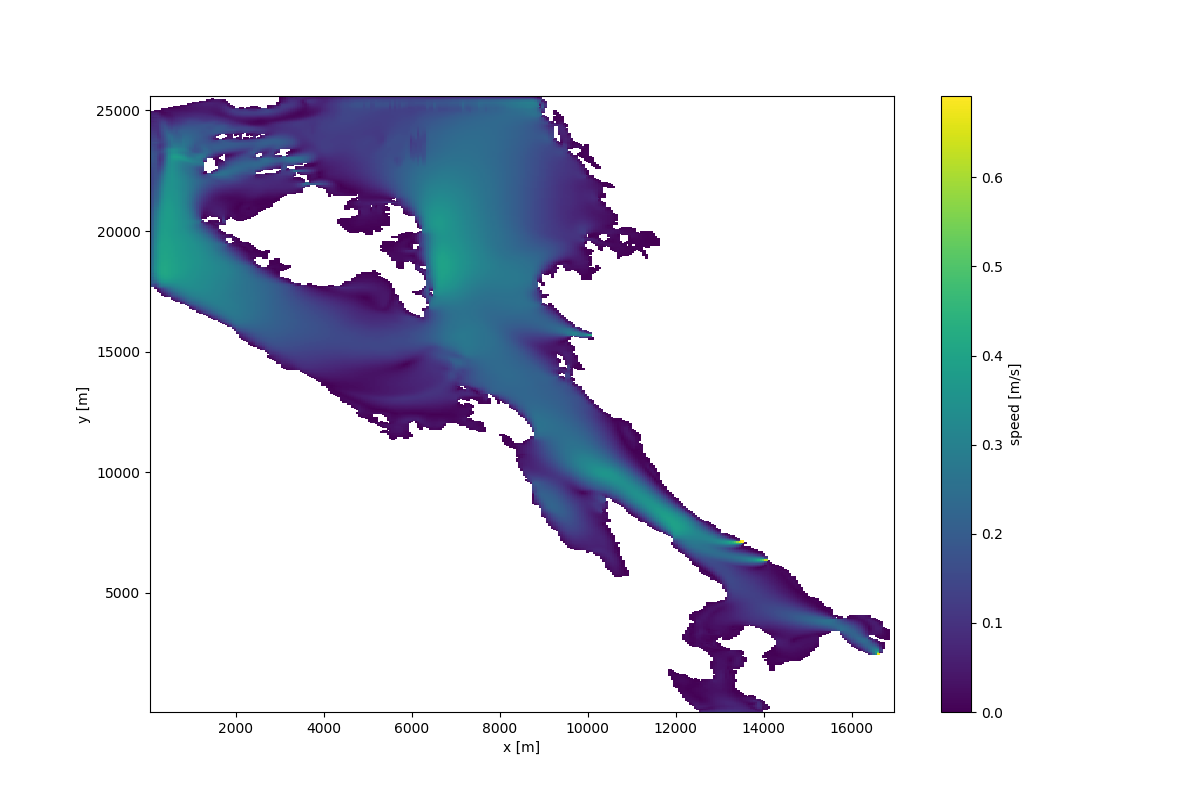

Text(0,0.5,'y [m]')

In [4]:

# Coordinates (unit m)
xc = np.array(data.variables['xc'][:])
yc = np.array(data.variables['yc'][:])
zc = np.array(data.variables['zc'][:])
# Time coordinate is given as "days since 2013-06-01 00:00"
# and must be converted to seconds
tc = np.array(data.variables['time'][:]) * 24*60*60

# Velocity components (unit m/s)
# The current components are stored as u_east, v_north and the weirdly named w_velocity, which is the z-component
u_east  = data.variables['u_east']
v_north = data.variables['v_north']
w_up    = data.variables['w_velocity']

# Calculate speed for surface layer
# order of indices are [t, z, y, x]
speed = np.sqrt(u_east[0,0,:,:]**2 + v_north[0,0,:,:]**2 + w_up[0,0,:,:]**2)

# Plot horizontal current speed
fig = plt.figure(figsize = (12, 8))
plt.pcolormesh(xc, yc, speed)
plt.colorbar(label = 'speed [m/s]')
plt.xlabel('x [m]')
plt.ylabel('y [m]')

In [4]:
xmin =  5000
xmax = 15000
ymin =  6000
ymax = 16000
Nz   = 42
Nt   = 48
        
xc, yc, zc, tc, u, v, w = get_data_subset(data, xmin, xmax, ymin, ymax, Nz, Nt)
f = interpolator(xc, yc, zc, tc, u, v, w)

print('Total memory [GB]: ', 3*u.size*4/2**30)


# Set initial position [x, y, z]
Nx = 5
Ny = 5
Nz = 25
X0 = np.zeros((3, Nx*Ny*Nz))

x = np.linspace( 9100,  9600, Nx)
y = np.linspace(12000, 12500, Ny)
z = np.linspace(50, 300, Nz)
x, y, z = np.meshgrid(x,y,z)
X0[0,:] = x.flatten()
X0[1,:] = y.flatten()
X0[2,:] = z.flatten()

# Initial and final time in seconds since start of file
T0   = 0
Tmax = 12*3600
# Timestep (in seconds)
h    = 600

# Construct interpolator
Xs, Ts = trajectory(X0, T0, Tmax, h, f, rk2)

Total memory [GB]:  0.7920842170715332


In [6]:
xmin =  4000
xmax = 14000
ymin = 6000
ymax = 16000
Nz   = 42
Nt   = 48
        
xc, yc, zc, tc, u, v, w = get_data_subset(data, xmin, xmax, ymin, ymax, Nz, Nt)
#f = interpolator(xc, yc, zc, tc, u, v, w)

#u = np.ascontiguousarray(u.transpose(3,2,1,0)).astype(np.float64)
#v = np.ascontiguousarray(v.transpose(3,2,1,0)).astype(np.float64)
#w = np.ascontiguousarray(w.transpose(3,2,1,0)).astype(np.float64)

xc = xc.astype(np.float64)
yc = yc.astype(np.float64)
zc = zc.astype(np.float64)
tc = tc.astype(np.float64)

print('Total memory [GB]: ', 3*u.size*8/2**30)

Total memory [GB]:  1.5841684341430664


In [7]:
xc

array([ 4000.        ,  4053.33325195,  4106.66650391,  4160.        ,
        4213.33300781,  4266.66650391,  4320.        ,  4373.33300781,
        4426.66650391,  4480.        ,  4533.33300781,  4586.66650391,
        4640.        ,  4693.33300781,  4746.66650391,  4800.        ,
        4853.33300781,  4906.66650391,  4960.        ,  5013.33300781,
        5066.66650391,  5120.        ,  5173.33300781,  5226.66650391,
        5280.        ,  5333.33300781,  5386.66650391,  5440.        ,
        5493.33300781,  5546.66650391,  5600.        ,  5653.33300781,
        5706.66650391,  5760.        ,  5813.33300781,  5866.66650391,
        5920.        ,  5973.33300781,  6026.66650391,  6080.        ,
        6133.33300781,  6186.66650391,  6240.        ,  6293.33300781,
        6346.66650391,  6400.        ,  6453.33300781,  6506.66650391,
        6560.        ,  6613.33300781,  6666.66650391,  6720.        ,
        6773.33300781,  6826.66650391,  6880.        ,  6933.33300781,
      

In [7]:
#u = u.astype(np.float64)
#v = v.astype(np.float64)
#w = w.astype(np.float64)
np.save('x.npy',xc)
np.save('y.npy',yc)
np.save('z.npy',zc)
np.save('t.npy',tc)
np.save('u.npy',u.astype(np.float64))
np.save('v.npy',v.astype(np.float64))
np.save('w.npy',w.astype(np.float64))

print(xc.shape,yc.shape,zc.shape,tc.shape)

NotImplementedError: MaskedArray.tofile() not implemented yet.

In [10]:
u.shape

(48, 42, 187, 188)

In [9]:
f = np.empty((3,tc.shape[0]*xc.shape[0]*yc.shape[0]*zc.shape[0]))

In [13]:
f[0] = u.transpose(0,3,2,1).ravel(order='F').astype(np.float64)
f[1] = v.transpose(0,3,2,1).ravel(order='F').astype(np.float64)
f[2] = w.transpose(0,3,2,1).ravel(order='F').astype(np.float64)

In [22]:
del f, u, v, w

In [8]:
from quadvariatevectorinterpolation import TrivectorQuadvariateSpline

In [15]:
vct = TrivectorQuadvariateSpline(tc,xc,yc,zc,f)

In [28]:
vct(0,np.array((xc[10],yc[11],zc[12])))

array([ 3.75707876e-67, -4.69661485e-68, -1.10499833e-68])

In [34]:
u[0,0,0,102]

0.006868165

In [32]:
np.nonzero(u)

(array([ 0,  0,  0, ..., 47, 47, 47]),
 array([ 0,  0,  0, ..., 41, 41, 41]),
 array([  0,   0,   0, ..., 157, 157, 157]),
 array([101, 102, 103, ...,  53,  54,  55]))

In [16]:
tc

array([    0.,  1200.,  2400.,  3600.,  4800.,  6000.,  7200.,  8400.,
        9600., 10800., 12000., 13200., 14400., 15600., 16800., 18000.,
       19200., 20400., 21600., 22800., 24000., 25200., 26400., 27600.,
       28800., 30000., 31200., 32400., 33600., 34800., 36000., 37200.,
       38400., 39600., 40800., 42000., 43200., 44400., 45600., 46800.,
       48000., 49200., 50400., 51600., 52800., 54000., 55200., 56400.])

In [6]:
#nu = u.ravel(order='F')
#nv = v.ravel(order='F')
#nw = w.ravel(order='F')

In [7]:
#nu.shape

In [ ]:
vel = TrivariateSpline(xc,#.astype(np.float64),
                       yc,#.astype(np.float64),
                       zc,#.astype(np.float64),
                       tc/1200,#.astype(np.float64),
                       u,
                       v,
                       w
                      )

In [18]:
np.nonzero(u)

(array([  0,   0,   0, ..., 175, 175, 175]),
 array([114, 114, 114, ...,   0,   0,   0]),
 array([ 0,  0,  0, ..., 11, 11, 11]),
 array([ 0,  1,  2, ..., 45, 46, 47]))

In [20]:
u[0,113,0,1]

0.0

<IPython.core.display.Javascript object>


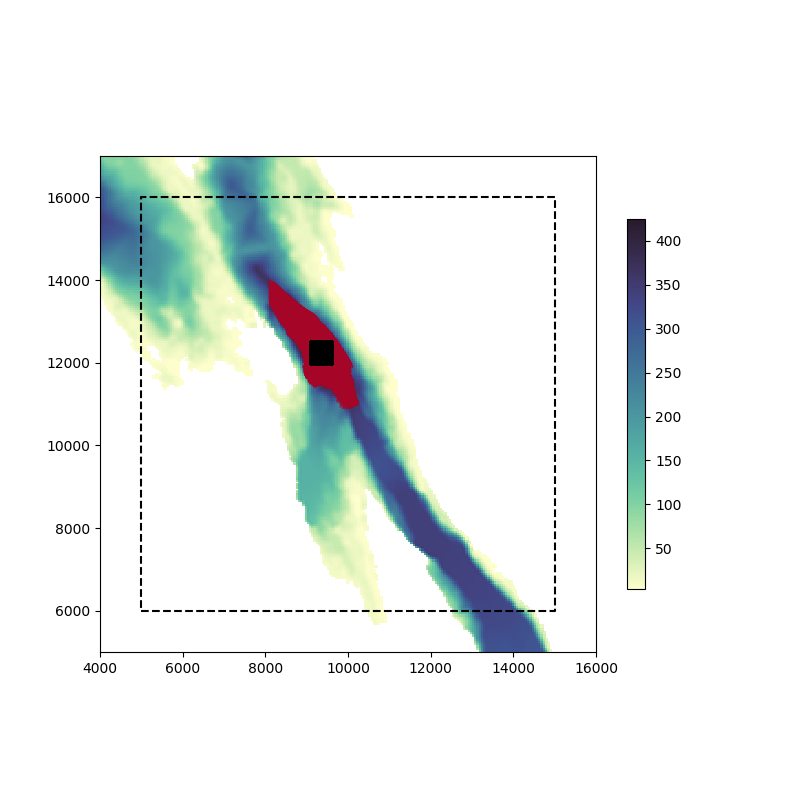

(5000, 17000)

In [34]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111, aspect = 'equal')
# Plot depth
xc0 = np.array(data.variables['xc'][:])
yc0 = np.array(data.variables['yc'][:])
mesh = ax.pcolormesh(xc0, yc0, data.variables['depth'], cmap = cmocean.cm.deep, zorder = 0)
plt.colorbar(mesh,shrink = 0.6)
# plot outline of subset
ax.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin], '--', c = 'k')
# Plot trajectory (in xy-plane)
ax.plot(Xs[:,0], Xs[:,1], c = '#A60628', lw = 1, alpha = 0.5, zorder = 1)
ax.scatter(Xs[0,0,:], Xs[0,1,:], marker = '.', c = 'k', s = 10, zorder = 2)

ax.set_xlim(xmin-1000, xmax+1000)
ax.set_ylim(ymin-1000, ymax+1000)


<IPython.core.display.Javascript object>


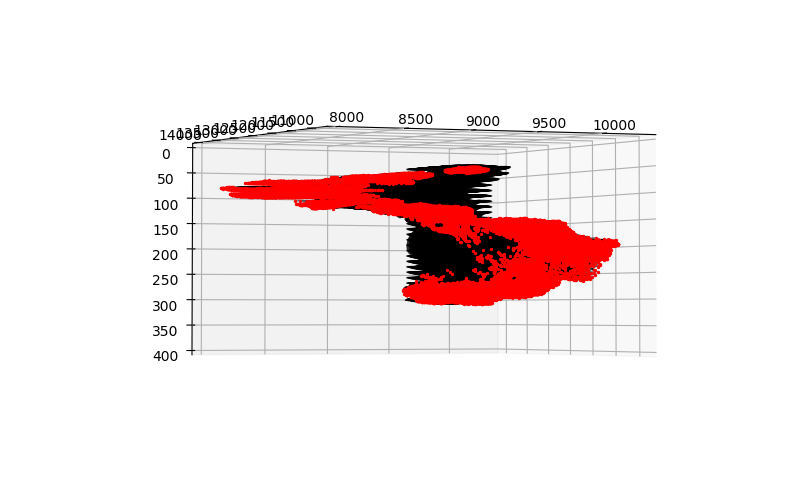

(74, 3, 62500)
62500


In [35]:
fig = plt.figure(figsize = (8, 5))
ax = fig.gca(projection='3d')
print(Xs.shape)
count = 0
for i in range(Xs.shape[2]):
    if Xs[0,0,i] != Xs[-1,0,i]:
        count += 1
#        ax.scatter(Xs[ 0,0,i], Xs[ 0,1,i], Xs[ 0,2,i], '.', c = 'k', s = 5)
        ax.scatter(Xs[-1,0,i], Xs[-1,1,i], Xs[-1,2,i], '.', c = 'r', s = 2)
        ax.plot(Xs[:,0,i], Xs[:,1,i], Xs[:,2,i], c = 'k', lw = 1, alpha = 0.5)

ax.set_zlim(400, 0)
print(count)

<IPython.core.display.Javascript object>


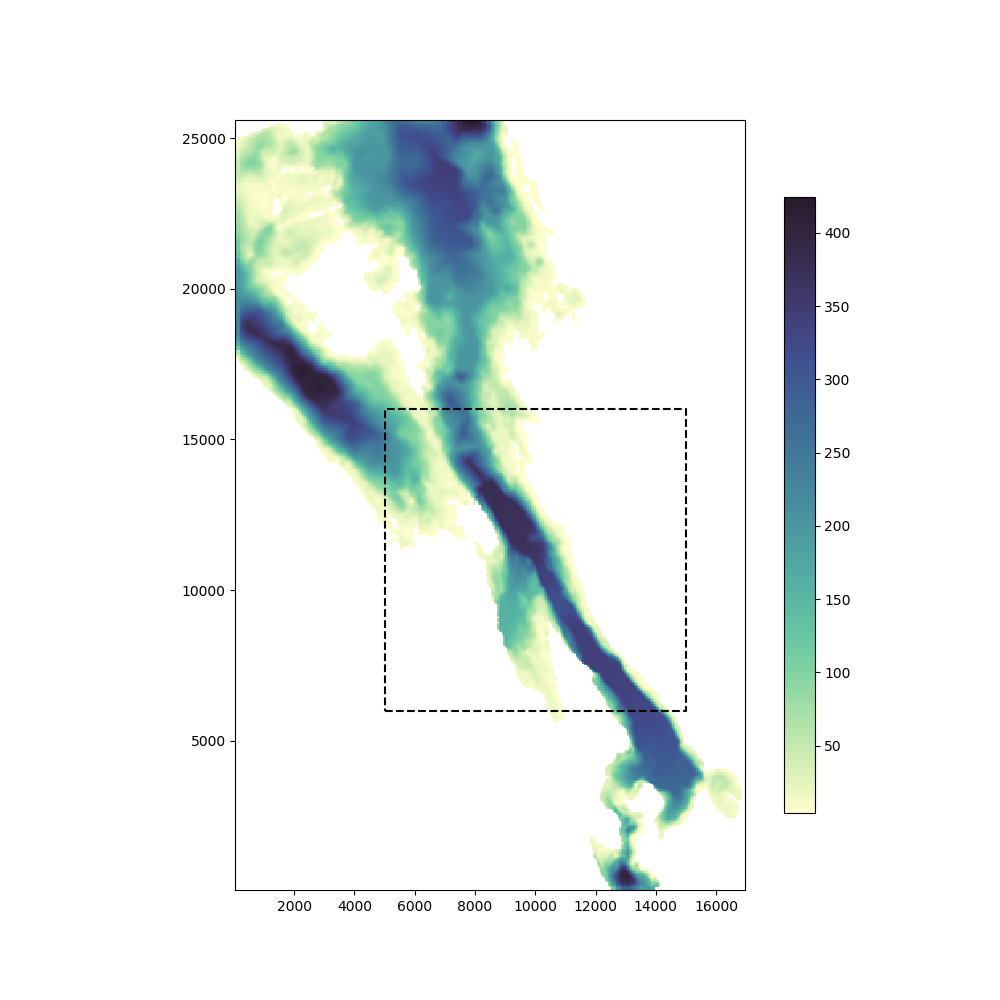

In [12]:
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111, aspect = 'equal')
# Plot depth
mesh = ax.pcolormesh(xc0, yc0, data.variables['depth'], cmap = cmocean.cm.deep)
plt.colorbar(mesh, shrink = 0.8)
# plot outline of subset
ax.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin], '--', c = 'k')


# Map plots

<IPython.core.display.Javascript object>


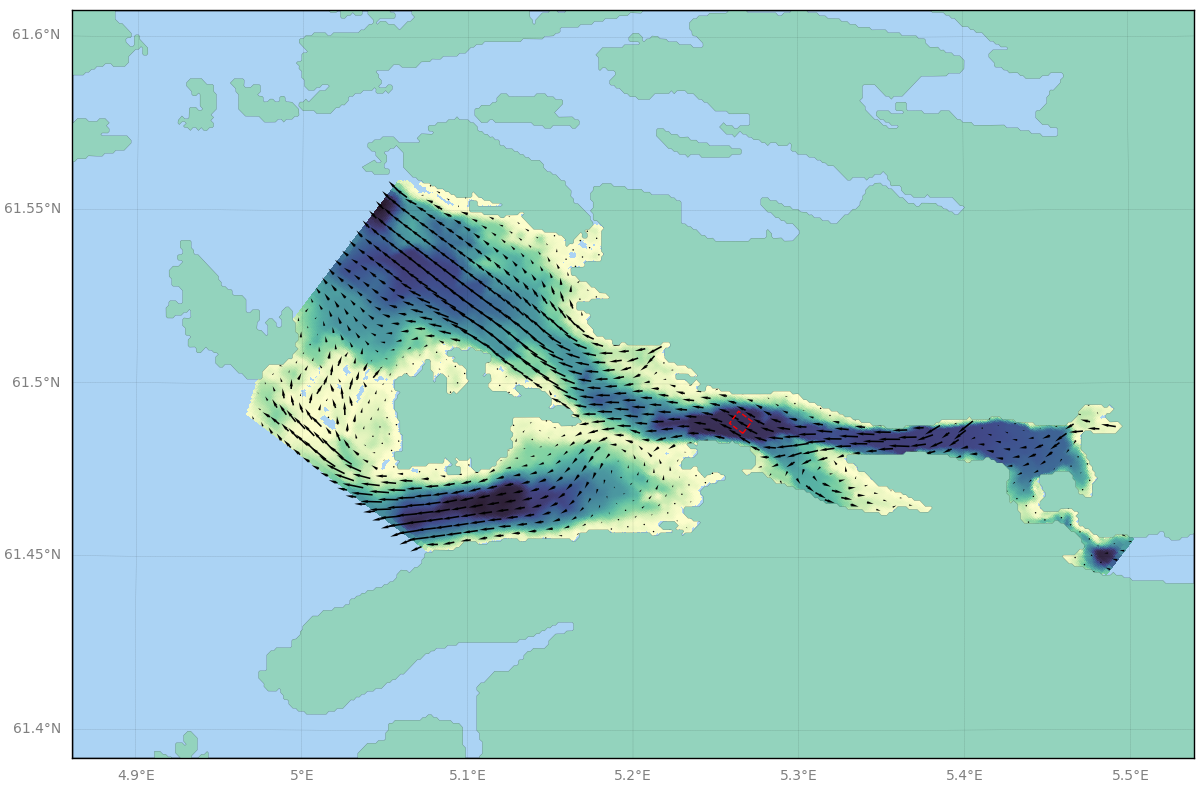

In [40]:
# Map plotting library
# requires installation of basemap from conda
# you may have to add the conda-forge repository
from mpl_toolkits.basemap import Basemap

# Create a figure object, and an axes instance, with projection info
fig = plt.figure(figsize=(12,8))
# Define some colors and variables, and create a map.
seacolor  = (171/255, 211/255, 244/255)
landcolor = (147/255, 211/255, 189/255)
lat_0  = 61.5 # Latitude of map center
lon_0  = 5.2  # Longitude of map center
scale  = 1.2  # change scale to change area covered by map
width  = 30000 * scale # width of map in meters
height = 20000 * scale # height of map in meters
m = Basemap(
    lat_0      = lat_0,   # Latitude at center of map
    lon_0      = lon_0,   # Longitude at center of map
    width      = width,   # Width of map (in meters)
    height     = height,  # Height of map (in meters)
    resolution = 'f',     # Resolution of coastlines, 'c'rude, 'l'ow, 'i'ntermediate, 'h'igh, 'f'ine
    projection = 'stere'  # Map projection, 'stere' is 'stereographic'
)

# Draw land, sea, parallels and meridians
linewidth = 0.1
alpha     = 0.5
# Fill background with seacolor
m.drawmapboundary(fill_color=seacolor)
# Fill continents with landcolor, and lakes with seacolor
m.fillcontinents(color=landcolor, lake_color=seacolor)
# Draw coastlines with a thin black line
m.drawcoastlines(linewidth = linewidth)
# draw grid of parallels and meridians.
m.drawparallels(np.arange(-90.,90,0.05), linewidth = linewidth, alpha = alpha, labels=[1,0,0,0])
m.drawmeridians(np.arange(-180.,180,0.1), latmax = 90, linewidth = linewidth, alpha = alpha, labels=[0,0,0,1])

# Open the currentdata file
datapath = '../data/samples_NSEW_20130601-20130602.nc'
data = nc.Dataset(datapath)

# Coordinates (latitude and longitude)
lons = np.array(data.variables['gridLons'][:])
lats = np.array(data.variables['gridLats'][:])

# Velocity components (unit m/s)
u_east  = data.variables['u_east']
v_north = data.variables['v_north']

# Depth
depth = data.variables['depth']
# Plot depth using colormap especially crafted to convey deepness
# https://matplotlib.org/cmocean/
m.pcolormesh(lons, lats, depth[:,:], latlon = True, cmap = cmocean.cm.deep)

# plot vectorplot of currents (in the horizontal plane)
it = 0 # Time index
iz = 0 # Depth index
step = 7 # plot only every step vector
m.quiver(
    lons[::step, ::step], lats[::step,::step], # position of each vector
    u_east[it, iz, ::step, ::step], v_north[it, iz, ::step, ::step], # vector components
    latlon = True, width = 0.0014, headwidth = 2, scale = 20 # Some parameters to tweak appearance
    # See matplotlib docs for details:
    # https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.quiver.html
)


# Plot an outline to indicate study area
# (here I've used extent of suggested initial conditions)
outline_xmin =  9100
outline_xmax =  9600
outline_ymin = 12000
outline_ymax = 12500
# First, use look up indices of outline in xy-coordinates
xc0 = np.array(data.variables['xc'][:])
yc0 = np.array(data.variables['yc'][:])
imin = np.searchsorted(xc0, outline_xmin)
imax = np.searchsorted(xc0, outline_xmax)
jmin = np.searchsorted(yc0, outline_ymin)
jmax = np.searchsorted(yc0, outline_ymax)
# Then, look up the lon-lat coordinates of those points
# llcrn = lower left corner, lrcrnr = lower right corner, etc
llcrnlon = data.variables['gridLons'][jmin, imin]
lrcrnlon = data.variables['gridLons'][jmin, imax]
urcrnlon = data.variables['gridLons'][jmax, imax]
ulcrnlon = data.variables['gridLons'][jmax, imin]
llcrnlat = data.variables['gridLats'][jmin, imin]
lrcrnlat = data.variables['gridLats'][jmin, imax]
urcrnlat = data.variables['gridLats'][jmax, imax]
ulcrnlat = data.variables['gridLats'][jmax, imin]

# Then, plot outline
# Note the keyword argument latlon=True which is required when the input is longitude and latitude
# otherwise, they would be interpreted as xy-coordinates of the map
# (which are different xy-coordinates from the dataset)
m.plot([llcrnlon, lrcrnlon, urcrnlon, ulcrnlon, llcrnlon], [llcrnlat, lrcrnlat, urcrnlat, ulcrnlat, llcrnlat], '--', c = 'r', lw = 1, latlon = True)

# tight_layout doesn't work well with basemap, adjust manually
plt.subplots_adjust(left = 0.06, right = 0.995, bottom = 0.05, top = 0.99)
plt.savefig('currentmap.png', dpi = 120)

# Attempt at 3D-plot of fjord

<IPython.core.display.Javascript object>


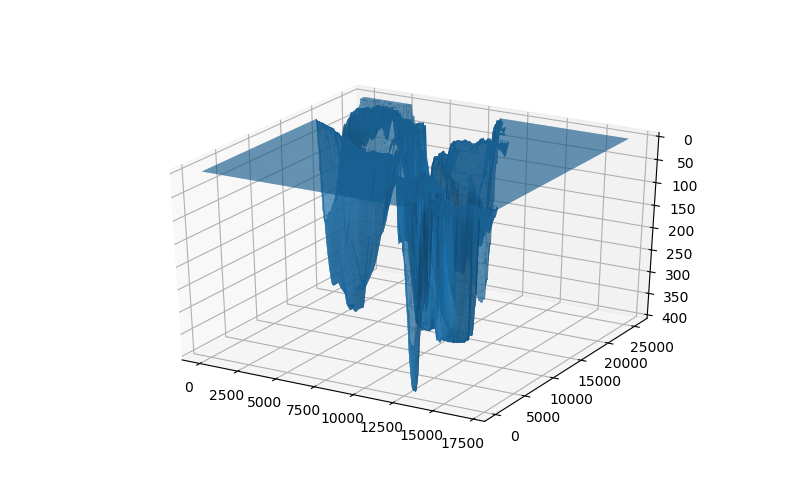

(400, 0)

In [32]:
xc0 = np.array(data.variables['xc'][:])
yc0 = np.array(data.variables['yc'][:])
x, y = np.meshgrid(xc0, yc0)
dep = np.array(data.variables['depth'][:,:].filled(0.0))

fig = plt.figure(figsize = (8, 5))
ax = fig.gca(projection='3d')

ax.plot_trisurf(x.flatten(), y.flatten(), dep.flatten())
ax.set_zlim(400, 0)